## Plotting our code
Plotting the code and seeing the time steps, with relevant data including the Total Energy decreasing due to the chemical potential,
$$
w = \frac{\delta E}{\delta u} = -\epsilon^2 \Delta u - F^{\prime}(u)
$$
where w is the variational derivative of $E$
$$
E(u) = \int_{\Omega} (F(u) + \frac{\epsilon^2}{2} \left |\nabla u \right|^2)
$$

Use This to plot the concentrations energy decreasing, and other data

In [10]:
'''import pickle
import matplotlib.pyplot as plt
import CHSolver
import CHReporter

# Step 1: Load the saved data
filename = '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(one-half).pkl'  # Adjust the filename if necessary
CHReporter.report_saved_data(filename)
with open(filename, 'rb') as file:
    loaded_data = pickle.load(file)

# Step 2: Extract the numerical solutions and equation data
ch_num_sol_data = loaded_data.get('ch_num_sol', [])
ch_eqn_data = loaded_data.get('ch_eqn_data', {})

# Step 3: Plot the data for each saved time step
time_marches_per_save = 5
for kk, num_sol_cur in enumerate(ch_num_sol_data):
    adjusted_kk = kk * time_marches_per_save
    fig, ax = plt.subplots(figsize=(8, 8))
    CHSolver.plot_still_shot(fig, ax, ch_eqn_data, num_sol_cur, adjusted_kk)
    plt.show()'''

"import pickle\nimport matplotlib.pyplot as plt\nimport CHSolver\nimport CHReporter\n\n# Step 1: Load the saved data\nfilename = '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(one-half).pkl'  # Adjust the filename if necessary\nCHReporter.report_saved_data(filename)\nwith open(filename, 'rb') as file:\n    loaded_data = pickle.load(file)\n\n# Step 2: Extract the numerical solutions and equation data\nch_num_sol_data = loaded_data.get('ch_num_sol', [])\nch_eqn_data = loaded_data.get('ch_eqn_data', {})\n\n# Step 3: Plot the data for each saved time step\ntime_marches_per_save = 5\nfor kk, num_sol_cur in enumerate(ch_num_sol_data):\n    adjusted_kk = kk * time_marches_per_save\n    fig, ax = plt.subplots(figsize=(8, 8))\n    CHSolver.plot_still_shot(fig, ax, ch_eqn_data, num_sol_cur, adjusted_kk)\n    plt.show()"

## Initializing the Data
- prepping the data from our tensor in pytorch -> numpy using .numpy() if the instance is a tensor

This section loads all of the data to create the design matrix

Each Basis function has equal dimensions, Continue!


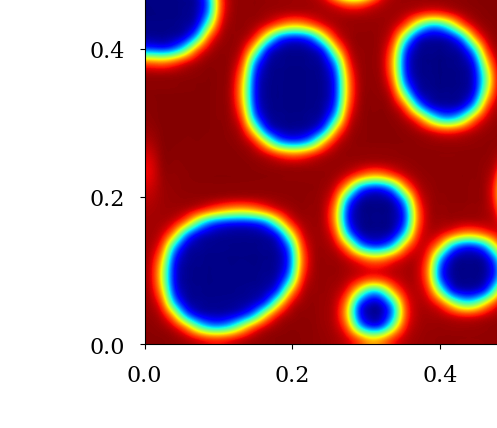

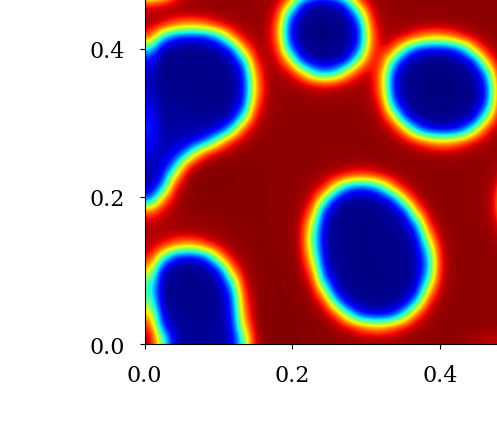

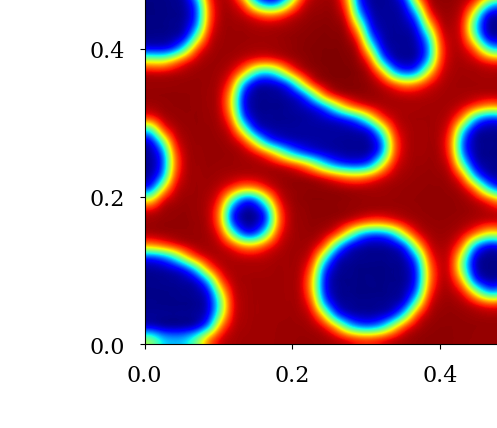

In [11]:
import numpy as np
import pickle
import CHSolver
import CHReporter
import torch
import warnings
from CommonTools.fileio_tools import save, open_pickled_file

# change file name accordingly
filenames = [
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(1).pkl', # f(xx) = 1
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(linear).pkl', # f(xx) = 1/2*xx + 1
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(quad).pkl'  # f(xx) = 0.25*xx**2 + 0.5
]

# Open files
file = [open_pickled_file(filenames[i]) for i in range(len(filenames))]

# Load the Cahn-Hilliard numerical solution data, add more depending if we need more basis functions
ch_num_sol_1, ch_num_sol_2, ch_num_sol_3 = [file[i]['ch_num_sol'] for i in range(len(filenames))]

# If ch_num_sol is a PyTorch tensor, convert to numpy
# (assuming all are of the same type for simplicity)
if isinstance(ch_num_sol_1, torch.Tensor):
    ch_num_sol_1, ch_num_sol_2, ch_num_sol_3 = [x.numpy() for x in [ch_num_sol_1, ch_num_sol_2, ch_num_sol_3]]

# to check if shapes are matching...
if ch_num_sol_1.shape == ch_num_sol_2.shape == ch_num_sol_3.shape:
    x = True
    print("Each Basis function has equal dimensions, Continue!")
else:
    x = False
    warnings.warn("WARNING: Time steps are different, change the time steps to solve for xi")  # If the time steps are different

## Creating our Basis Function matrix
1. we break down the 3d array by iterating over each time step saved and applying the basis function to the data
2. after iterating and transforming the data, we vstack the temp_stack into vstacked_array
3. then store the vstacked_array into the stacked_slices array
4. once every basis function is iterated through, we cna take our vstacked array and use hstack to separate our basis functions

In [15]:
import numpy as np

# Define the basis functions as trajectories with different mobility functions
f1 = ch_num_sol_1  # Shape (n_saves + 1, 64, 64)
f2 = ch_num_sol_2  # Shape (11, 64, 64)
f3 = ch_num_sol_3  # Shape (11, 64, 64)

# Use list comprehension for efficient concatenation of flattened arrays
basis_func_matrix = np.column_stack([np.concatenate(traj.reshape(-1, traj.shape[0])) for traj in [f1, f2, f3]])

# Output the shape of the basis function matrix and a sample of its content for verification
print("Shape of the basis function matrix:", basis_func_matrix.shape)
print("First 5 rows of the matrix:\n", basis_func_matrix[:5, :])
print("Last 6 rows of the matrix:\n", basis_func_matrix[-6:, :])


Shape of the basis function matrix: (45056, 3)
First 5 rows of the matrix:
 [[0.24636683 0.24636683 0.24636683]
 [0.21575077 0.21575077 0.21575077]
 [0.29328123 0.29328123 0.29328123]
 [0.2828759  0.2828759  0.2828759 ]
 [0.27808989 0.27808989 0.27808989]]
Last 6 rows of the matrix:
 [[ 0.96402335  0.97784845  0.94813245]
 [ 0.96471288  0.98044673  0.95332433]
 [ 0.96699511  0.98152944  0.91157445]
 [ 0.96976323  0.98451172  0.76556591]
 [ 0.97246088  0.97722603  0.42429885]
 [ 0.97466155  0.92052046 -0.05077959]]


## Creating our True solution (b matrix)
- applying the steps above, only this time we transform the data using the mobility function

In [ ]:
'''import numpy as np
# first we need to create our true solution "b" matrix with the true data with the 
# cahn-hilliard mobility parameter to try and recover it in our "x" vector (Ax = b SINDY)
# Initialize an empty list to store the flattened slices

# Initialize an empty list to store the 2D slices (time shots)
concatenated_arrays= []

# Iterate over each time shot to flatten the 2D slice and append it to stacked_slices
concatenated_data = np.concatenate([ch_num_sol_1[i, :, :].flatten() for i in range(ch_num_sol_1.shape[0])])
concatenated_arrays.append(concatenated_data)

# Vertically stack all the 2D slices to create a single large 2D array
# Needed to transpose for column vector
true_b = np.vstack(concatenated_arrays).T

# Now, true_b can be used as the "true solution" in your equation Ax = b
print(true_b.shape)'''

'import numpy as np\n# first we need to create our true solution "b" matrix with the true data with the \n# cahn-hilliard mobility parameter to try and recover it in our "x" vector (Ax = b SINDY)\n# Initialize an empty list to store the flattened slices\n\n# Initialize an empty list to store the 2D slices (time shots)\nconcatenated_arrays= []\n\n# Iterate over each time shot to flatten the 2D slice and append it to stacked_slices\nconcatenated_data = np.concatenate([ch_num_sol_1[i, :, :].flatten() for i in range(ch_num_sol_1.shape[0])])\nconcatenated_arrays.append(concatenated_data)\n\n# Vertically stack all the 2D slices to create a single large 2D array\n# Needed to transpose for column vector\ntrue_b = np.vstack(concatenated_arrays).T\n\n# Now, true_b can be used as the "true solution" in your equation Ax = b\nprint(true_b.shape)'

Concatenated array shape: (45056, 3)
Summed array shape: (45056, 1)


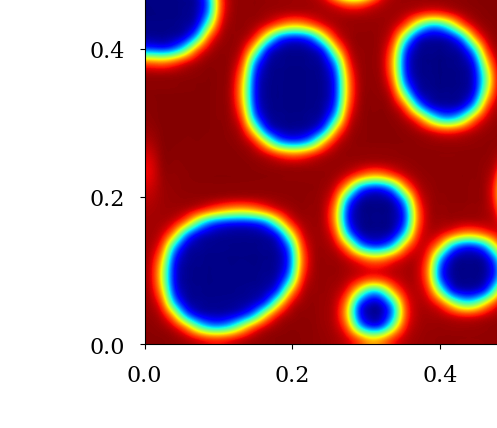

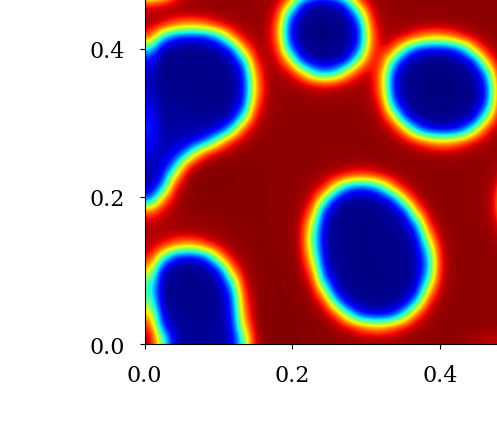

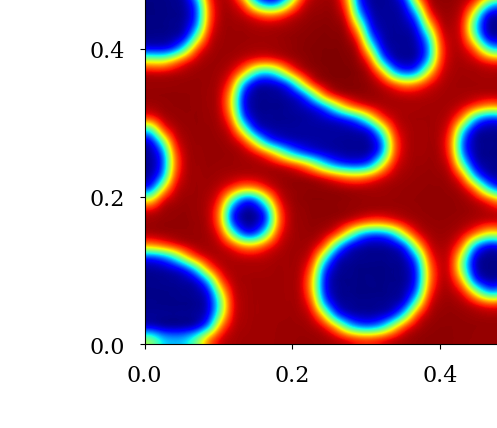

In [ ]:
import numpy as np

# change file name accordingly
filenames = [
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(1).pkl',
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(linear).pkl',
    '/Users/reese/Documents/Research summer 2023/VSCODE -Research/mobility(quad).pkl'
]

# Open files
file = [open_pickled_file(filenames[i]) for i in range(len(filenames))]

# Load the Cahn-Hilliard numerical solution data
custom_ch_1, custom_ch_2, custom_ch_3 = [file[i]['ch_num_sol'] for i in range(len(filenames))]

# If ch_num_sol is a PyTorch tensor, convert to numpy
if isinstance(custom_ch_1, torch.Tensor):
    custom_ch_1, custom_ch_2, custom_ch_3 = [x.numpy() for x in [custom_ch_1, custom_ch_2, custom_ch_3]]

# Check if shapes are matching
if custom_ch_1.shape != custom_ch_2.shape or custom_ch_1.shape != custom_ch_3.shape:
    warnings.warn("WARNING: Time steps are different, change the time steps to solve for xi")

# Define the basis functions and concatenate them
# Reshape to column vector
f1 = custom_ch_1.reshape(-1, 1)  
f2 = custom_ch_2.reshape(-1, 1)
f3 = custom_ch_3.reshape(-1, 1)

# Stack the basis functions horizontally
concatenated_arrays = np.hstack([f1, f2, f3])
print("Concatenated array shape:", concatenated_arrays.shape)

# Sum the basis functions and reshape to put back into a 2d.
true_b = np.sum(concatenated_arrays, axis=1).reshape(-1, 1)
print("Summed array shape:", true_b.shape)


### After Returning our b matrix, we will then apply regression such as LASSO, LS, and SLS to solve for our $\hat{\xi}$ column vector
$$
\hat{\xi} = \begin{pmatrix} 
\hat{\xi_1} \\
\hat{\xi_2} \\
\hat{\xi_3}
\end{pmatrix}
$$

# LASSO regression

In [ ]:
from sklearn.linear_model import Lasso
import numpy as np

# Lasso model

def perform_Lasso(library_matrix, target, alpha, warm_start = True):
    '''
    LASSO function to increase sparsity in the xi matrix when calculating (basis_func_matrix @ Xi) = target
    params:
    - library_matrix: This is the design matrix created from basis functions
    - target: this is our b matrix we are trying to get "close" to when solving for xi
    - alpha: parameter to increase or decrease sparsity (increasing the value adds sparsity)
    - warm_start: usually we leave true but can turn off
    '''
    model = Lasso(alpha = alpha, fit_intercept = False, max_iter = 10000, warm_start = True)
    model.fit(library_matrix, target)
    xi = model.coef_
    return xi

# Running lasso function for each column of xyz_dot
alpha = .001
xi_LAS = perform_Lasso(basis_func_matrix, true_b, alpha)
print(xi_LAS.shape)
print(xi_LAS.reshape([3,1]))

(3,)
[[0.99930414]
 [0.99905172]
 [0.9989228 ]]


# Ordinary Least Squares
- $\text{Find } \hat{\xi} \text{ such that: } \arg\min_{\hat{\xi}} || A\hat{\xi} - b ||^2 \text{  where  }\hat{\xi} = (\xi^\top x)^{-1} x^\top b$

In [ ]:
import numpy as np

xi_LS = np.linalg.lstsq(basis_func_matrix, true_b, rcond=None)[0]
print(xi_LS)

[[1.]
 [1.]
 [1.]]


In [ ]:
def perform_STLS(Theta, xi_initial, target, threshold, max_iter):
    '''
    SLS algorithm to add sparsity to xi by using threshold and max_iter, and checks if the prior iterated xi is equal to the new xi
    params:
    - Theta: Library matrix of basis functions for each column in the matrix
    - xi_initial: xi_LS matrix obtained from performing Least Squares
    - target: target matrix (i.e. xyz_dot)
    - threshold: threshold value - usually 0.1
    - max_iter: maximum number of iterations - usually 100, but the algorithm will break if the prior iterated xi is equal to the new xi
    '''
    # Initialize xi and iteration count
    xi = xi_initial.copy()
    xi_prev = np.zeros_like(xi) # Store a copy of zeros with the same shape as xi
    iter_count = 0
        
    while iter_count < max_iter:
        # Store a copy of the xi from the previous iteration
        xi_prev = xi.copy()
            
        # Find small indices and update xi
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
            
        for dim in range(xi.shape[1]):  # Iterate through each dimension, i.e. x, y, z
            new_Theta = Theta[:, ~small_indices[:, dim]] # Remove columns that are 0'd out for the current dimension
            
            # As a saftey step, if new_Theta becomes empty, skip this iteration
            if new_Theta.shape[1] == 0:
                continue
            
            updated_values = np.linalg.lstsq(new_Theta, target[:, dim], rcond=None)[0]
            
            # Update xi with new values for the current dimension
            xi[~small_indices[:, dim], dim] = updated_values
            
        # Break the loop if the prior iterated xi is equal to the new xi
        if np.all(xi == xi_prev):
            break
                
        iter_count += 1
    return xi

# Perform SLS to add sparsity
threshold = 0.1
max_iter = 100
xi_SLS = perform_STLS(basis_func_matrix, xi_LS, true_b, threshold, max_iter)
print(xi_SLS.shape)
print(xi_SLS)

(3, 1)
[[1.]
 [1.]
 [1.]]
